In [ ]:
""" TODO
x Grab data from MOABB

Decimation to reduce data points

Initial Noise Filters
- Filter out eye artifacts and head movements (Maxwell and SSS)
- Normalize channel wise

Epoching
- Create -0.1 to 0.9ms stimulus epochs

Label epochs as containing target or not based on moabb data (still having trouble loading data; harder than I thought to work with large datasets)
Demonstrate interperson variability 
- Plot epochs containing target averaged across-epochs with SD
- Plot epochs not containing target average across-epochs with SD Sort based on person

Demonstrate interchannel variability
- Plot channel-wise average for target epochs across epochs 
- ML will be done channel-wise

Classification Pipelines
- Butterworth Bandpass (0.5-20Hz frequencies) + regression on PCA(?)
- adaptive xDawn (spatial filter) + sLDA
- RG (spatial filter) + sLDA

PRESENTATION
- CodeSnap Extension VScode
"""

' TODO\nx Grab data from MOABB\n\nDecimation to reduce data points\n\nInitial Noise Filters\n- Filter out eye artifacts and head movements (Maxwell and SSS)\n- Normalize channel wise\n\nEpoching\n- Create -0.1 to 0.9ms stimulus epochs\n\nLabel epochs as containing target or not based on moabb data (still having trouble loading data; harder than I thought to work with large datasets)\nDemonstrate interperson variability \n- Plot epochs containing target averaged across-epochs with SD\n- Plot epochs not containing target average across-epochs with SD Sort based on person\n\nDemonstrate interchannel variability\n- Plot channel-wise average for target epochs across epochs \n- ML will be done channel-wise\n\nClassification Pipelines\n- Butterworth Bandpass (0.5-20Hz frequencies) + regression on PCA(?)\n- adaptive xDawn (spatial filter) + sLDA\n- RG (spatial filter) + sLDA\n\nPRESENTATION\n- CodeSnap Extension VScode\n'

# Other

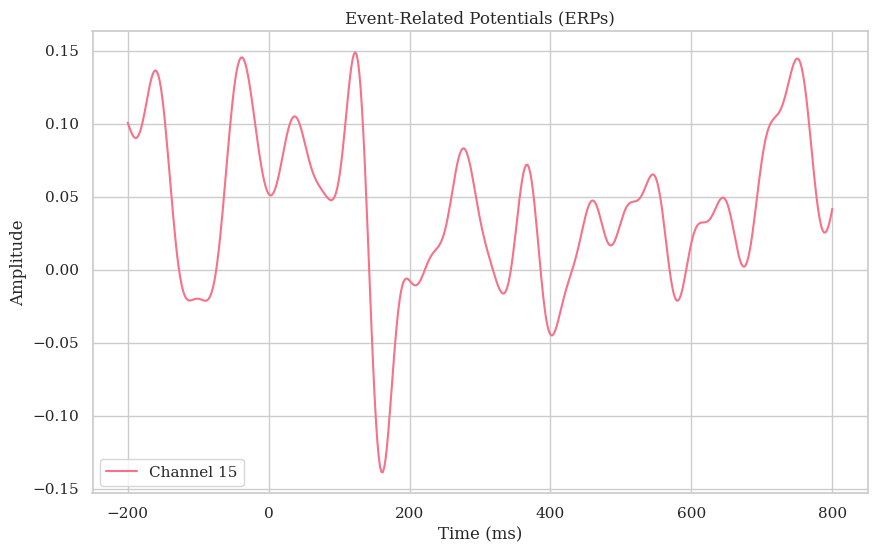

In [ ]:
all_eeg_channels = alsobye_dcbias.get_data(picks='eeg')
events = alsobye_dcbias.get_data(picks='stim')[0]
event_indices = np.where(events == 33286)[0] #33286 is id for nontarget event in the dataset 

# Define the epoch window around each event (adjust as needed)
epoch_start = -200  # milliseconds before the event
epoch_end = 800    # milliseconds after the event

# Convert epoch boundaries to sample indices
start_index = int(epoch_start * 0.001 * fs)  # 512 Hz sampling rate
end_index = int(epoch_end * 0.001 * fs)

# Extract ERP epochs around each event
erp_epochs = [all_eeg_channels[:, i + start_index:(i + end_index + 1)] for i in event_indices]

# Standardize each channel independently
erp_epochs_standardized = [(epoch - np.mean(epoch)) / np.std(epoch) for epoch in erp_epochs]

# Average across epochs to obtain ERP
erp_standardized = np.mean(erp_epochs_standardized, axis=0)

time_points = np.linspace(epoch_start,epoch_end, erp_standardized.shape[1])
# Plot the ERP waveforms
plt.figure(figsize=(10, 6))
# plt.plot(time_points, erp[14])
#for i in range(erp_standardized.shape[0]):
i = 14
plt.plot(time_points, erp_standardized[i], label=f'Channel {i + 1}')

plt.title('Event-Related Potentials (ERPs)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
X, y, metadata = paradigm.get_data(full_dataset, subjects=[1])

In [ ]:
from mne.decoding import Vectorizer
from pyriemann.estimation import Xdawn, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

from moabb.evaluations import WithinSessionEvaluation

In [ ]:

# metadata  # 10896 epochs, 8 recording sessions, 2 runs of 2 phases
# X.shape # 10896 epochs, 16 channels, 513 time points (512Hz x 1s trial) 
'''
(wet Silver/Silver Chloride electrodes positioned at 
FP1, FP2, F5, AFz, F6, T7, Cz, T8, P7, P3, Pz, P4, P8, O1, Oz, O2 
according to the 10/20 international system.)
'''
# y.shape # 10896 labels for each epoch
from sklearn.preprocessing import FunctionTransformer
from scipy.signal import decimate

In [ ]:
pipelines = {}
labels_dict = {"Target": 1, "NonTarget": 0}

pipelines["RG+LDA"] = make_pipeline(
    FunctionTransformer(decimate, kw_args={'q': 10}),
    XdawnCovariances(
        nfilter=2, classes=[labels_dict["Target"]], estimator="lwf", xdawn_estimator="scm"), #supervised spatial filter
    TangentSpace(), 
    LDA(solver="lsqr", shrinkage="auto"),
)

# pipelines["Xdawn+LDA"] = make_pipeline(
#     Xdawn(nfilter=2, estimator="scm"), 
#     Vectorizer(), 
#     LDA(solver="lsqr", shrinkage="auto")
# )


In [ ]:
evaluation = WithinSessionEvaluation(
    paradigm=paradigm, datasets=full_dataset, suffix="test"
)
results = evaluation.process(pipelines)

In [ ]:
test_data = test_dataset.get_data()

In [ ]:
for eeg in data_set:
    epochs.extend(epoch for signal in labeled)

In [ ]:
classifier_pipelines = {
    'PCA': (make_pipeline()),
    'xDawn + sLDA': (make_pipeline(Xdawn(),LDA(shrinkage='auto',solver='eigen'))),
    'RG + sLDA': (make_pipeline(TangentSpace(metric='riemann'),LDA(shrinkage='auto', solver='eigen')))
}